In [33]:
import numpy as np
import pandas as pd
import time
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sentence_transformers import SentenceTransformer, util
from nltk.tokenize import sent_tokenize
import torch
import nltk
from transformers import AutoTokenizer, AutoModel
import openai
import tiktoken

## 데이터 읽기

In [5]:
df = pd.read_csv('kor_news_data.csv')
df

,date,time,title,content
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세계는 핀테크 혁명 ...
1,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다. 파운드는...
2,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블록체인을 바라보...
3,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 해킹이 어렵고 ...
4,2017-01-01,2017-01-01 10:33:04,5대 키워드로 보는 2016년 핀테크 트렌드,2016년 한 해 동안 다양한 핀테크 얘기가 쏟아졌다. IT 기업부터 유통회사까지 ...
...,...,...,...,...
154,2017-01-10,2017-01-10 20:24:55,비트코인·페이팔 테러지원 수단 악용,"IS, 인니로 자금 보낼 때 이용… 은행 거치지 않아 추적 어려워세계 금융의 혁신으..."
155,2017-01-10,2017-01-10 16:31:03,[여적]김연아 스케이트와 문화유산의 자격,문화재와 문화유산은 같은 개념이 아니다. 문화재(文化財) 용어는 일본이 영어의 Cu...
156,2017-01-10,2017-01-10 15:34:03,은행·금투업권 블록체인 시범사업 올해 본격화,"정은보 금융위 부위원장, “블록체인 융합 적극 추진” (지디넷코리아=송주영 기자)국..."
157,2017-01-10,2017-01-10 18:06:00,중국 위안화 하락에 비트코인 가격 급등세,[한겨레] 새해 들어 3년여 만에 1000달러 돌파중국 정부 자본통제 피해 국외송...


In [7]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_df = df.groupby('date').size()
datewise_df

date
2017-01-01     6
2017-01-02    23
2017-01-03    32
2017-01-04    12
2017-01-05    18
2017-01-06    31
2017-01-07     1
2017-01-08     6
2017-01-09    10
2017-01-10    20
dtype: int64

count    10.00000
mean     15.90000
std      10.68176
min       1.00000
25%       7.00000
50%      15.00000
75%      22.25000
max      32.00000
dtype: float64


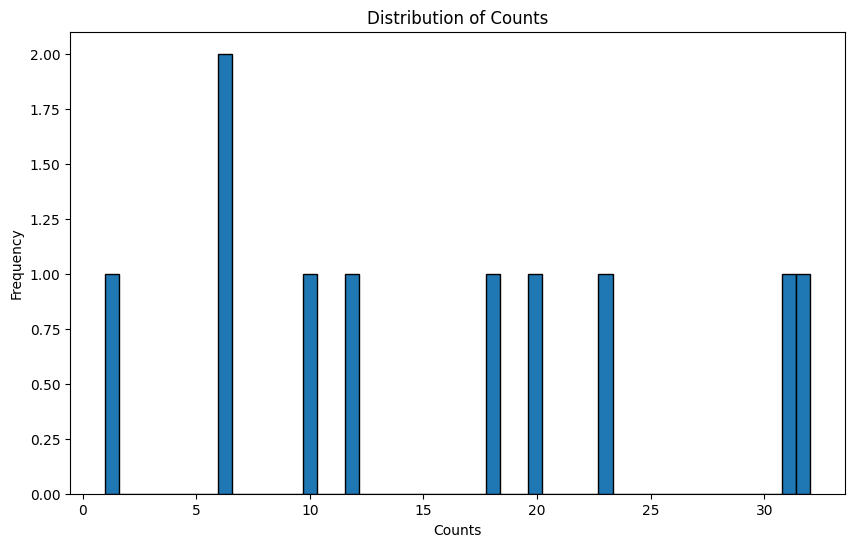

In [11]:
# 기본 통계 요약
print(datewise_df.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_df.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

## 유사도 기반 기사 중복 제거 전처리
- sBERT와 cosine 유사도 사용

In [25]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('jhgan/ko-sbert-multitask')
model = AutoModel.from_pretrained('jhgan/ko-sbert-multitask')

# Mean Pooling Function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Tokenize and Create Embeddings
def create_sentence_embeddings(contents):
    encoded_input = tokenizer(contents, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings

# Cosine Similarity Calculation Function
def cosine_similarity(embedding1, embedding2):
    return util.pytorch_cos_sim(embedding1, embedding2)

# Compute Similarity Matrix and Statistics
def compute_similarity_statistics(contents):
    sentence_embeddings = create_sentence_embeddings(contents)
    similarity_matrix = []

    for i in range(len(sentence_embeddings)):
        row = []
        for j in range(len(sentence_embeddings)):
            similarity = cosine_similarity(sentence_embeddings[i], sentence_embeddings[j]).item()
            row.append(similarity)
        similarity_matrix.append(row)

    return similarity_matrix

def cluster_and_filter_articles(group):
    try:
        contents = group['content'].tolist()
        sentence_embeddings = create_sentence_embeddings(contents)
        similarity_matrix = compute_similarity_statistics(contents)

        clusters = []
        visited = np.zeros(len(group), dtype=bool)

        for i in range(len(group)):
            if not visited[i]:
                similar_articles = np.where(np.array(similarity_matrix[i]) > 0.6)[0]
                clusters.append(similar_articles)
                visited[similar_articles] = True

        representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]
        return group.iloc[representative_indices].reset_index(drop=True)
    except Exception as e:
        print(f"Error at index {group.name}: {e}")
        return pd.DataFrame()


In [23]:
# Group and Filter Data
grouped_data = df.groupby('date')
filtered_data = pd.DataFrame()

for date, group in grouped_data:
    try:
        filtered_group = cluster_and_filter_articles(group)
        filtered_data = pd.concat([filtered_data, filtered_group], ignore_index=True)
    except Exception as e:
        print(f"Error at date {date}: {e}")

print(filtered_data)

          date                 time  \
0   2017-01-01  2017-01-01 07:00:00   
1   2017-01-01  2017-01-01 15:15:04   
2   2017-01-01  2017-01-01 16:03:04   
3   2017-01-01  2017-01-01 07:02:03   
4   2017-01-02  2017-01-02 18:47:22   
..         ...                  ...   
69  2017-01-10  2017-01-10 03:02:03   
70  2017-01-10  2017-01-10 11:42:05   
71  2017-01-10  2017-01-10 11:19:53   
72  2017-01-10  2017-01-10 16:31:03   
73  2017-01-10  2017-01-10 20:24:55   

                                              title  \
0                        한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라   
1   英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...   
2                       [신년기획]블록체인, 금융권 넘어 IT기업도 관심   
3               2017년 주식 투자…IT, 인프라 ‘솔깃’ 해외주식도 담아보자   
4                 공공기관·기업 대상으로 랜섬웨어 다량 유포…관계자 주의 필요   
..                                              ...   
69                      김윤종 “성공하고 싶다면, 마음껏 놀고 연애하라”   
70                     “블록체인, 4차 산업혁명의 고속도로 역할 할 것”   
71                  "비트코인·페이팔까지 테러자금

In [65]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_filtered_data = filtered_data.groupby('date').size()
datewise_filtered_data

date
2017-01-01     4
2017-01-02     9
2017-01-03    12
2017-01-04    10
2017-01-05     7
2017-01-06     9
2017-01-07     1
2017-01-08     6
2017-01-09     8
2017-01-10     8
dtype: int64

count    10.000000
mean      7.400000
std       3.134042
min       1.000000
25%       6.250000
50%       8.000000
75%       9.000000
max      12.000000
dtype: float64


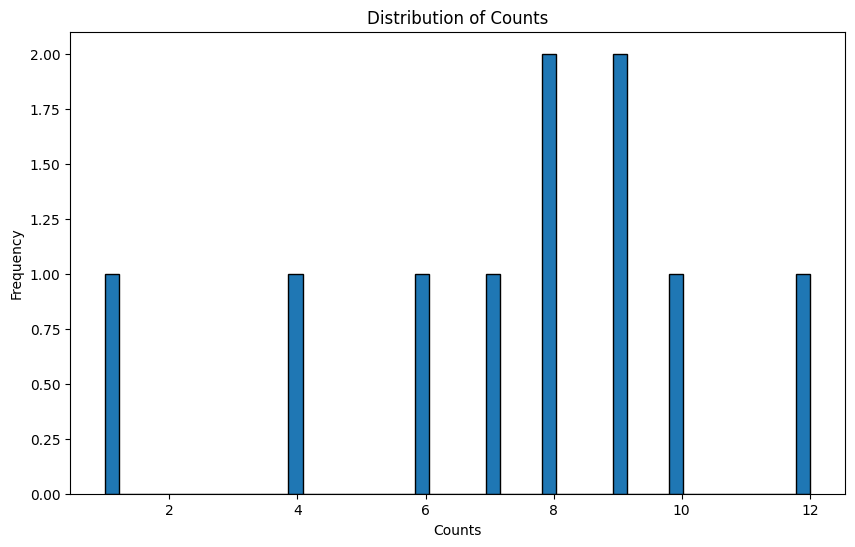

In [27]:
# 기본 통계 요약
print(datewise_filtered_data.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_filtered_data.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

## API로 sentiment 추출하기

In [83]:
openai.api_key = ""
# 각자 개인 api 키 입력

In [95]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo-0125")
max_tokens = 16300

def get_completion_16k(prompt, model="gpt-3.5-turbo-0125"):
    try:
        # 텍스트를 토큰으로 변환합니다.
        prompt_tokens = encoding.encode(prompt)
        
        # 토큰의 길이를 확인하고, max_tokens를 초과하지 않도록 조정합니다.
        if len(prompt_tokens) > max_tokens:
            prompt_tokens = prompt_tokens[:max_tokens]
            # 인코딩된 토큰을 다시 텍스트로 변환합니다.
            # tiktoken 라이브러리에는 decode 메서드가 없을 수 있으므로, 이 부분은 필요에 따라 조정해야 합니다.
            allowed_text = encoding.decode(prompt_tokens)
        else:
            allowed_text = prompt

        # 수정된 텍스트로 API 요청을 보냅니다.
        response = openai.ChatCompletion.create(
            model=model,
            messages=[{"role": "user", "content": allowed_text}],
            temperature=0,
        )
        result = response.choices[0].message["content"]
    except Exception as e:
        print(f"An error occurred: {e}")
        result = 9999
    return result

def get_completion_with_delay(x):
    result = get_completion_16k(x)
    time.sleep(2)
    return result

In [96]:
prompt = "이전 지시사항은 모두 무시하십시오. 당신은 금융 전문가로 가정하며 금융자산 추천 경험이 있습니다. 만약 기사의 제목과 내용이 다음날 한국에서 거래되는 암호화폐의 가격에 좋은 소식이 확실하다면 1에 가까운 수를, 나쁜 소식이 확실하다면 –1에 가까운 수, 불확실하거나 암호화폐 가격에 대한 정보가 부족한 경우 0에 가까운 수로 답변해주세요. 다시 말해, 뉴스 기사 제목과 내용을 읽고 다음날 암호화폐 가격에 대해 좋은 소식인지, 아니면 나쁜 소식인지, 혹은 불확실한지를 –1과 1 사이의 실수로만 답하세요. 기사 내에 여러 개의 기사나 내용이 있다면 종합적으로 고려하여 여러개의 숫자가 아닌 하나의 숫자로만 답변하세요. 설명이나 추가적인 텍스트 없이 숫자만 답변하세요."

In [98]:
# 결과를 저장할 빈 데이터프레임을 초기화합니다.
result = pd.DataFrame()

# data의 모든 행을 100행씩 처리합니다.
for i in range(0, len(filtered_data), 100):
    subset = filtered_data.iloc[i:i+100]
    subset['score'] = (prompt + '제목:' + subset['title'] + '내용:' + subset['content']).apply(get_completion_with_delay)
    result = pd.concat([result, subset])

result.reset_index(drop=True, inplace=True)
result

C:\Users\boyu571\AppData\Local\Temp\ipykernel_28172\1682520508.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['score'] = (prompt + '제목:' + subset['title'] + '내용:' + subset['content']).apply(get_completion_with_delay)


,date,time,title,content,score
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세계는 핀테크 혁명 ...,0.5
1,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다. 파운드는...,-1
2,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블록체인을 바라보...,0.5
3,2017-01-01,2017-01-01 07:02:03,"2017년 주식 투자…IT, 인프라 ‘솔깃’ 해외주식도 담아보자",[헤럴드경제=김지헌 기자] 올해도 지루한 박스피(박스권에 갇힌 코스피) 장세 연출될...,1
4,2017-01-02,2017-01-02 18:47:22,공공기관·기업 대상으로 랜섬웨어 다량 유포…관계자 주의 필요,[아시아경제 박소연 기자]이스트소프트는 2일 국내 주요 국가 기관과 기업을 대상으로...,-1
...,...,...,...,...,...
69,2017-01-10,2017-01-10 03:02:03,"김윤종 “성공하고 싶다면, 마음껏 놀고 연애하라”",[동아일보]아메리칸드림 이룬 김윤종씨김윤종 꿈희망미래재단 이사장은 한국에서 청소년 ...,0.5
70,2017-01-10,2017-01-10 11:42:05,"“블록체인, 4차 산업혁명의 고속도로 역할 할 것”","- 금융정보기술융합학회 보고서“일자리 창출 등 경제난 돌파정부, 기술개발 적극 나...",1
71,2017-01-10,2017-01-10 11:19:53,"""비트코인·페이팔까지 테러자금 조달에 악용…추적 어려워""",(자카르타=연합뉴스) 황철환 특파원 = 가상화폐 비트코인과 온라인 결제 서비스 페이...,-1
72,2017-01-10,2017-01-10 16:31:03,[여적]김연아 스케이트와 문화유산의 자격,문화재와 문화유산은 같은 개념이 아니다. 문화재(文化財) 용어는 일본이 영어의 Cu...,0.5


In [99]:
result_df = result

## 각 기사별 sentiment를 전처리 후 daily sentiment 추출

In [101]:
def process_score(input_df, column_name):
    df = input_df.copy()  # 입력 DataFrame 복사

    # 'column_name' 열을 float으로 변환하는 함수
    def convert_to_float(value):
        try:
            return float(value)
        except ValueError:
            return None

    # 임시 열 생성 (예: column_name + '_1')
    temp_column_name = column_name + '_1'
    df[temp_column_name] = df[column_name].apply(convert_to_float)

    # temp_column_name 열이 비어있는 행을 처리하여 값을 추출하여 채우기
    def fill_empty_score(row, idx):
        try:
            if pd.isna(row[temp_column_name]):
                if '\n' in str(row[column_name]):
                    if '컨퍼런스 개최 예정\n\n' in str(row[column_name]):
                        return float(0)
                    else:
                        lines = row[column_name].split("\n")
                        numbers = [float(line.split()[-1]) for line in lines if line.split()[-1].replace('.','',1).isdigit()]
                        average = sum(numbers) / len(numbers) if numbers else None
                        return average
                else:
                    numeric_values = re.findall(r'[-+]?\d*\.\d+|\d+', str(row[column_name]))
                    if numeric_values:
                        numeric_value = float(numeric_values[0])
                        if -1 <= numeric_value <= 1:
                            return numeric_value
            return row[temp_column_name]
        except Exception as e:
            print(f"Error in row index {idx}: {e}")
            return None

    # 각 행에 대해 fill_empty_score 함수 적용
    df[column_name] = [fill_empty_score(row, idx) for idx, row in df.iterrows()]

    # 임시로 생성한 열 삭제
    df.drop(columns=[temp_column_name], inplace=True)
    
    return df

In [102]:
# 함수를 호출하여 결과 확인
df_full = process_score(result_df, 'score')
df_full

In [104]:
final_df = df_full[df_full['score'].notna() & (df_full['score'] >= -1) & (df_full['score'] <= 1)]
final_df

,date,time,title,content,score
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세계는 핀테크 혁명 ...,0.5
1,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다. 파운드는...,-1.0
2,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블록체인을 바라보...,0.5
3,2017-01-01,2017-01-01 07:02:03,"2017년 주식 투자…IT, 인프라 ‘솔깃’ 해외주식도 담아보자",[헤럴드경제=김지헌 기자] 올해도 지루한 박스피(박스권에 갇힌 코스피) 장세 연출될...,1.0
4,2017-01-02,2017-01-02 18:47:22,공공기관·기업 대상으로 랜섬웨어 다량 유포…관계자 주의 필요,[아시아경제 박소연 기자]이스트소프트는 2일 국내 주요 국가 기관과 기업을 대상으로...,-1.0
...,...,...,...,...,...
69,2017-01-10,2017-01-10 03:02:03,"김윤종 “성공하고 싶다면, 마음껏 놀고 연애하라”",[동아일보]아메리칸드림 이룬 김윤종씨김윤종 꿈희망미래재단 이사장은 한국에서 청소년 ...,0.5
70,2017-01-10,2017-01-10 11:42:05,"“블록체인, 4차 산업혁명의 고속도로 역할 할 것”","- 금융정보기술융합학회 보고서“일자리 창출 등 경제난 돌파정부, 기술개발 적극 나...",1.0
71,2017-01-10,2017-01-10 11:19:53,"""비트코인·페이팔까지 테러자금 조달에 악용…추적 어려워""",(자카르타=연합뉴스) 황철환 특파원 = 가상화폐 비트코인과 온라인 결제 서비스 페이...,-1.0
72,2017-01-10,2017-01-10 16:31:03,[여적]김연아 스케이트와 문화유산의 자격,문화재와 문화유산은 같은 개념이 아니다. 문화재(文化財) 용어는 일본이 영어의 Cu...,0.5


In [109]:
# Group by the 'date' column and calculate the required statistics
grouped_df = final_df.groupby('date')['score'].agg(['mean', 'std', 'max', 'min']).reset_index()
grouped_df = grouped_df.rename(columns={'mean' : 'sentiment', 'std' : 'std','max' : 'max','min' : 'min'})
grouped_df

,date,sentiment,std,max,min
0,2017-01-01,0.250000,0.866025,1.0,-1.0
1,2017-01-02,0.444444,0.583333,1.0,-1.0
2,2017-01-03,0.318182,0.873863,1.0,-1.0
3,2017-01-04,-0.150000,0.747217,0.5,-1.0
4,2017-01-05,0.500000,0.707107,1.0,-1.0
5,2017-01-06,0.055556,0.845741,1.0,-1.0
6,2017-01-07,1.000000,NaN,1.0,1.0
7,2017-01-08,-0.083333,0.735980,0.5,-1.0
8,2017-01-09,0.062500,0.903861,1.0,-1.0
9,2017-01-10,0.000000,0.845154,1.0,-1.0


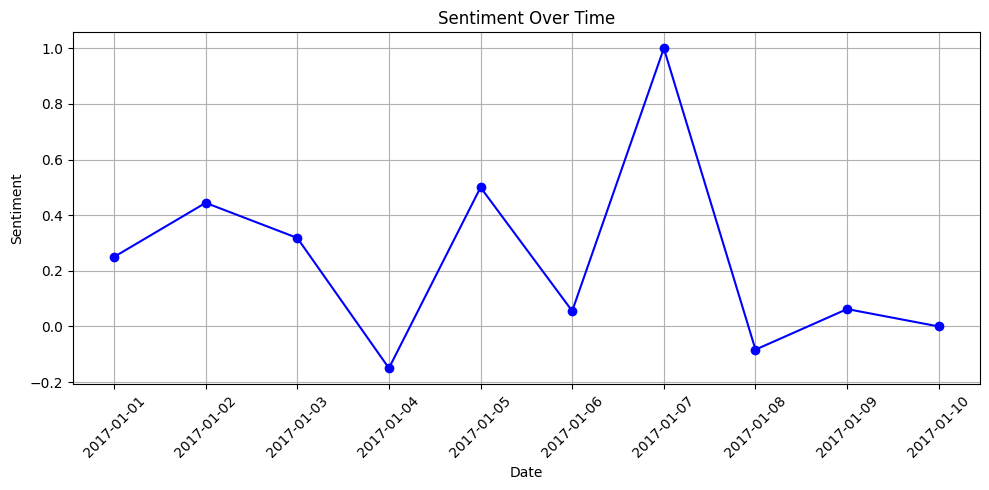

In [111]:
# 그래프 그리기
plt.figure(figsize=(10, 5))  # 그래프 크기 설정
plt.plot(grouped_df['date'], grouped_df['sentiment'], marker='o', linestyle='-', color='b')  # 꺾은선 그래프 그리기
plt.title('Sentiment Over Time')  # 그래프 제목
plt.xlabel('Date')  # x축 레이블
plt.ylabel('Sentiment')  # y축 레이블
plt.grid(True)  # 그리드 표시
plt.xticks(rotation=45)  # x축 레이블 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 표시